# Deep Learning with `Flux.jl`
---


The purpose of this notebook is to showcase one of the most popular deep learning frameworks in Julia: `Flux.jl`. The goal of our demonstration is to build a simple classification neural network.
   
   
*References for this notebook:*
*  [Flux.jl](https://fluxml.ai/Flux.jl/stable/)
*  Flux Neural Network tutorial: [Deep Learning with Julia](https://medium.com/coffee-in-a-klein-bottle/deep-learning-with-julia-e7f15ad5080b) (DSB, 2021)

### Outline of this notebook


- Generate a data set 
- Create neural network model
- Train model
- Visualize Results

### Libraries

Let first import the libraries that we will need for our example. 

In [1]:
# Graphics
using Plots 

# Data stucture
using DataFrames

# Statistics
using Statistics

# Machine Learning
using Flux

## Generate a data set 

In this short presentation, let simulate a data set as a toy example. It has the benefit of being self-contained, with no need to import data. Let generate two circumscribed clusters labeled as *class A* and *class B*. 

### Function to generate outer cluster: class A

In [2]:
function generateClassAdata(n)    
    θ  = 2π .* rand(1, n)
    r  = rand(1, n)/5 .+ 0.3
    x = @. r*cos(θ)
    y = @. r*sin(θ) + 0.5
        
    return vcat(x, y)
end

generateClassAdata (generic function with 1 method)

### Function to generate inner cluster: class B

In [3]:
function generateClassBdata(n)
    θ  = 2π .* rand(1, n)
    r  = rand(1, n)/3
    x = @. r*cos(θ)
    y = @. r*sin(θ) + 0.5
    
    return vcat(x, y)
end

generateClassBdata (generic function with 1 method)

### Data set

Each cluster contains the same amount of data points defined by the variable `sizeTraining`.

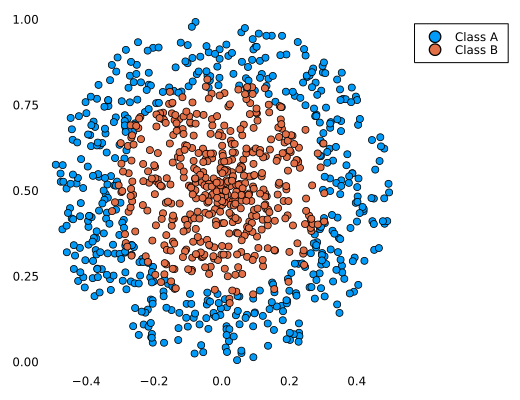

In [20]:
# Create our data
sizeTraining = 5000
classA = generateClassAdata(sizeTraining)
classB = generateClassBdata(sizeTraining)

# Visualize our data
num2visualize = 500

scatter(classA[1, 1:num2visualize],classA[2, 1:num2visualize], label = "Class A")
scatter!(classB[1, 1:num2visualize],classB[2, 1:num2visualize],
        xaxis = false, yaxis = false, grid = false,
        legend = :outertopright, label = "Class B", 
        size=(520,400))

## Create neural network model

Modeling neural network with `Flux.jl` is straightforward and tidy. We first use the function `Chain()` that assembles the layers to be called in sequence order. Here, we create dense layers with the function `Dense()`. We indicate how many input and output and the activation function.
For instance, our first layer is dense with two inputs, 25 outputs, and ReLU for activation function. Our second is a dense layer with input 25, output 1, and a sigmoid activation function. All the different layer types available in `Flux.jl` are described [here](https://fluxml.ai/Flux.jl/stable/models/layers/).

In [21]:
function NeuralNetwork()
    return Chain(
            # layer 1: 2 inputs, 5 outputs, 
            #          activation function: rectified linear Unit function (relu) defined as f(x) = max(0, x))
            Dense(2, 5,relu),
            # layer 2: 5 inputs, 5 outputs, 
            #          activation function: rectified linear Unit function (relu) defined as f(x) = max(0, x))
            Dense(5, 5,relu),
            # layer 3: 5 inputs, 1 output, 
            #          activation function: sigmoid function, defined as σ(x)= (1+e⁻ˣ)⁻¹
            Dense(5,1,x->σ.(x))
            )
end

NeuralNetwork (generic function with 1 method)

##### Image generated by open source software [NN-SVG](http://alexlenail.me/NN-SVG/index.html):

<center> <img src=images/nn.svg width="90%"> </center><br>

## Train model

Once we create the architecture of our neural network, it remains to define what [loss function](https://fluxml.ai/Flux.jl/stable/models/losses/) and [optimization algorithm](https://fluxml.ai/Flux.jl/stable/training/optimisers/) we are going to use for training.

In [22]:
# Generate a new model
m = NeuralNetwork()

# Define optimization algorithm: 
# Gradient descent with a learning rate η
η = 0.2
opt  = Descent(η)

# Define loss function
# loss(x, y) = sum(Flux.Losses.logitbinarycrossentropy(m(x), y)) # m(x), predicted values;
loss(x, y) = sum(Flux.Losses.binarycrossentropy(m(x), y)) # m(x), predicted values;

Our model is ready for training. But before starting, we compose our data set with the [`DataLoader` type](https://fluxml.ai/Flux.jl/stable/data/dataloader/) that handles the training iteration by constructing an object that iterates over mini-batches of data. Each mini-batch contains `batchsize` observations over the data.

In [23]:
# Compose data in batches
X  = hcat(classA, classB)
Y  = vcat(ones(sizeTraining), zeros(sizeTraining));
data = Flux.Data.DataLoader((X, Y'), batchsize=100,shuffle=true);

We present two methods to train the neural network model. The first method is direct and simple using the [`Flux.train!()` function](https://fluxml.ai/Flux.jl/stable/training/training/). The second option is to train in a more hand-operated way where it is possible to [customize the training loops](https://fluxml.ai/Flux.jl/stable/training/training/#Custom-Training-loops).

### Training scheme: option 1

Declare what parameters are going to be trained.   
It is possible to specify what layers need to be trained, which is helpful for transfer learning. Follow this [link](https://fluxml.ai/Flux.jl/stable/models/advanced/#Freezing-Layer-Parameters) to learn how to to not include all the model parameters.   

In [24]:
ps = Flux.params(m);

Define how many epochs will be used. (*Reminder: number of epochs is  hyperparameter that defines the number of times that a learning algorithm will handle the entire training data set.*)    

In [25]:
numEpochs = 20;

Time to Train the model!

In [26]:
for i in 1:numEpochs
    Flux.train!(loss, ps, data, opt)
end

In [27]:
outputModel = round.([mean(m(classA)) mean(m(classB))]; digits = 4)
println("Mean prediction probability using the class A training set: $(outputModel[1])")
println("Mean prediction probability using the class B training set: $(outputModel[2])")    

Mean prediction probability using the class A training set: 0.862
Mean prediction probability using the class B training set: 0.1106


### Training scheme: option 2

In [28]:
# Generate a new model
m2 = NeuralNetwork()
epochs = 20
loss2(x, y) = sum(Flux.Losses.binarycrossentropy(m2(x), y)) # m(x), predicted values
for epoch = 1:epochs
    for batch in data
        # compute gradient according to parameters values and 
        # apply results to the loss function for the batch d
        gs = Flux.gradient(Flux.params(m2)) do
            l = loss2(batch...)
        end
        # update the new parameters values according the gradients from 
        # the last iteration.
        Flux.Optimise.update!(opt, Flux.params(m2), gs)
    end
end

In [29]:
outputModel = round.([mean(m2(classA)) mean(m2(classB))]; digits = 4)
println("Mean prediction probability using the class A training set: $(outputModel[1])")
println("Mean prediction probability using the class B training set: $(outputModel[2])")

Mean prediction probability using the class A training set: 0.897
Mean prediction probability using the class B training set: 0.0994


## Results visualizations

### Training visualization

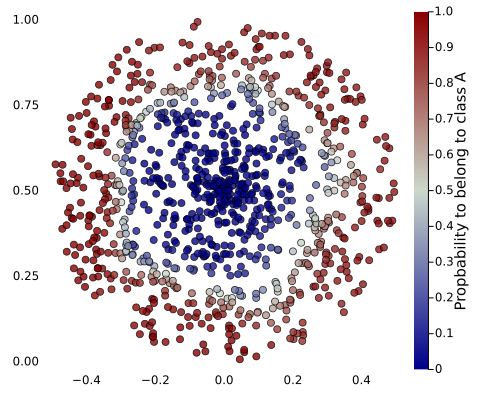

In [30]:
numSample = 500
scatter(classA[1,1:numSample],classA[2,1:numSample],zcolor=m(classA)', m = (:bluesreds, 0.8))
scatter!(classB[1,1:numSample],classB[2,1:numSample],zcolor=m(classB)',m = (:bluesreds, 0.8), 
    clim=(0, 1), legend=false,
    colorbar_title = string("Propbability to belong to class A"),
    xaxis = false, yaxis = false, grid = false,
    size = (480,400))

### Testing visualizations

#### Results on a testing data set

Generate the testing data set.

In [31]:
testSize = 1000
classAtest = generateClassAdata(testSize)
classBtest = generateClassBdata(testSize);

Apply the model on the testing data points.

In [32]:
resultsLabelClassA = m(classAtest) 
resultsLabelClassB = m(classBtest)

outputModel = round.([mean(resultsLabelClassA) mean(resultsLabelClassB)]; digits = 4)
println("Mean prediction probability using the class A training set: $(outputModel[1])")
println("Mean prediction probability using the class B training set: $(outputModel[2])")

Mean prediction probability using the class A training set: 0.8644
Mean prediction probability using the class B training set: 0.1112


#### Visualization

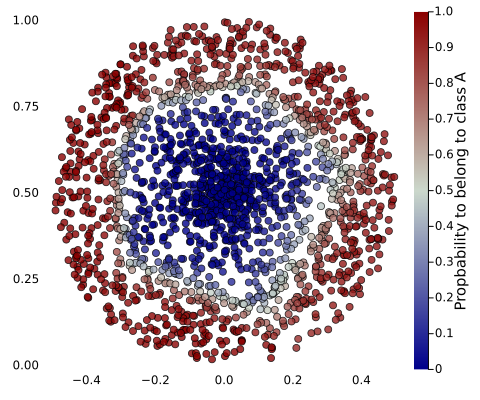

In [33]:
numSample = testSize
scatter(classAtest[1,1:numSample],classAtest[2,1:numSample],zcolor=resultsLabelClassA', m = (:bluesreds, 0.8))
scatter!(classBtest[1,1:numSample],classBtest[2,1:numSample],zcolor=resultsLabelClassB',m = (:bluesreds, 0.8), 
    clim=(0, 1), legend=false,
    colorbar_title = string("Propbability to belong to class A"),
    xaxis = false, yaxis = false, grid = false,
    size = (480,400))

#### Confusion matrix

In [34]:
DataFrame( :_ => ["Actual Class A", "Actual Class B"],
    Symbol("Predicted Class A") => [sum(collect(resultsLabelClassA').>= 0.5), sum(collect(resultsLabelClassB').>= 0.5)],
        Symbol("Predicted Class B") => [sum(collect(resultsLabelClassA').< 0.5), sum(collect(resultsLabelClassB').< 0.5)])       

,_,Predicted Class A,Predicted Class B
,String,Int64,Int64
1,Actual Class A,935,65
2,Actual Class B,81,919


In [ ]:
versioninfo()